In [1]:

import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
assets = ['SHEL','BP','TTE','XOM','CL=F']


In [3]:
end_date = datetime.today()
start_date = end_date - timedelta(days = 3*365)
print(start_date)
print(end_date)

2020-08-03 10:44:25.805763
2023-08-03 10:44:25.805763


In [5]:
adj_close_df = pd.DataFrame()
for asset in assets:
    data = yf.download(asset, start = start_date, end = end_date)
    adj_close_df[asset] = data['Adj Close']



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [6]:
print(adj_close_df)


                 SHEL         BP        TTE         XOM       CL=F
Date                                                              
2020-08-03  27.273148  19.077719  31.390020   36.065804  41.009998
2020-08-04  28.218258  20.502720  32.108063   37.107224  41.700001
2020-08-05  28.371273  20.684086  32.450775   37.431610  42.189999
2020-08-06  28.128244  20.088173  32.075436   37.252346  41.950001
2020-08-07  27.759201  19.846355  31.773533   37.081615  41.220001
...               ...        ...        ...         ...        ...
2023-07-27  60.799999  36.660000  59.169998  105.419998  80.089996
2023-07-28  60.939999  36.709999  59.910000  104.160004  80.580002
2023-07-31  61.630001  37.299999  60.849998  107.239998  81.800003
2023-08-01  61.020000  36.959999  60.349998  106.620003  81.370003
2023-08-02  59.919998  36.029999  58.299999  105.290001  79.489998

[755 rows x 5 columns]


In [7]:
log_returns = np.log(adj_close_df / adj_close_df.shift(1))
print(log_returns)

                SHEL        BP       TTE       XOM      CL=F
Date                                                        
2020-08-03       NaN       NaN       NaN       NaN       NaN
2020-08-04  0.034067  0.072036  0.022617  0.028467  0.016685
2020-08-05  0.005408  0.008807  0.010617  0.008704  0.011682
2020-08-06 -0.008603 -0.029233 -0.011634 -0.004801 -0.005705
2020-08-07 -0.013207 -0.012111 -0.009457 -0.004594 -0.017555
...              ...       ...       ...       ...       ...
2023-07-27 -0.029495 -0.011931 -0.009085  0.003135  0.016492
2023-07-28  0.002300  0.001363  0.012429 -0.012024  0.006100
2023-07-31  0.011259  0.015944  0.015568  0.029141  0.015027
2023-08-01 -0.009947 -0.009157 -0.008251 -0.005798 -0.005271
2023-08-02 -0.018191 -0.025484 -0.034559 -0.012553 -0.023375

[755 rows x 5 columns]


In [8]:
log_returns = log_returns.dropna()
print(log_returns)

                SHEL        BP       TTE       XOM      CL=F
Date                                                        
2020-08-04  0.034067  0.072036  0.022617  0.028467  0.016685
2020-08-05  0.005408  0.008807  0.010617  0.008704  0.011682
2020-08-06 -0.008603 -0.029233 -0.011634 -0.004801 -0.005705
2020-08-07 -0.013207 -0.012111 -0.009457 -0.004594 -0.017555
2020-08-10  0.019586  0.022376  0.006910  0.024333  0.017316
...              ...       ...       ...       ...       ...
2023-07-27 -0.029495 -0.011931 -0.009085  0.003135  0.016492
2023-07-28  0.002300  0.001363  0.012429 -0.012024  0.006100
2023-07-31  0.011259  0.015944  0.015568  0.029141  0.015027
2023-08-01 -0.009947 -0.009157 -0.008251 -0.005798 -0.005271
2023-08-02 -0.018191 -0.025484 -0.034559 -0.012553 -0.023375

[754 rows x 5 columns]


In [9]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)


          SHEL        BP       TTE       XOM      CL=F
SHEL  0.106176  0.101462  0.083958  0.082549  0.071483
BP    0.101462  0.121401  0.090167  0.089488  0.076254
TTE   0.083958  0.090167  0.095318  0.071595  0.061767
XOM   0.082549  0.089488  0.071595  0.107538  0.079996
CL=F  0.071483  0.076254  0.061767  0.079996  0.163686


In [10]:
# Définition des fonctions
def standard_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

def expected_return(weights, log_returns):
    return np.sum(log_returns.mean() * weights) * 252

def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate)

In [12]:
risk_free_rate = 0.03844
constraints = {'type': 'eq', 'fun' : lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(assets))]

In [13]:

initial_weights = np.array([1/len(assets)]*len(assets))
print(initial_weights)

[0.2 0.2 0.2 0.2 0.2]


In [14]:
def sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [19]:
print("Optimal Weights:")
for ticker, weight in zip(assets, optimal_weights):
 print(f"{ticker}: {weight:.4f}")
 
print()
optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)
print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights:
SHEL: 0.4673
BP: 0.0000
TTE: 0.0000
XOM: 0.5000
CL=F: 0.0327

Expected Annual Return: 0.3092
Expected Volatility: 0.3060
Sharpe Ratio: 0.8849


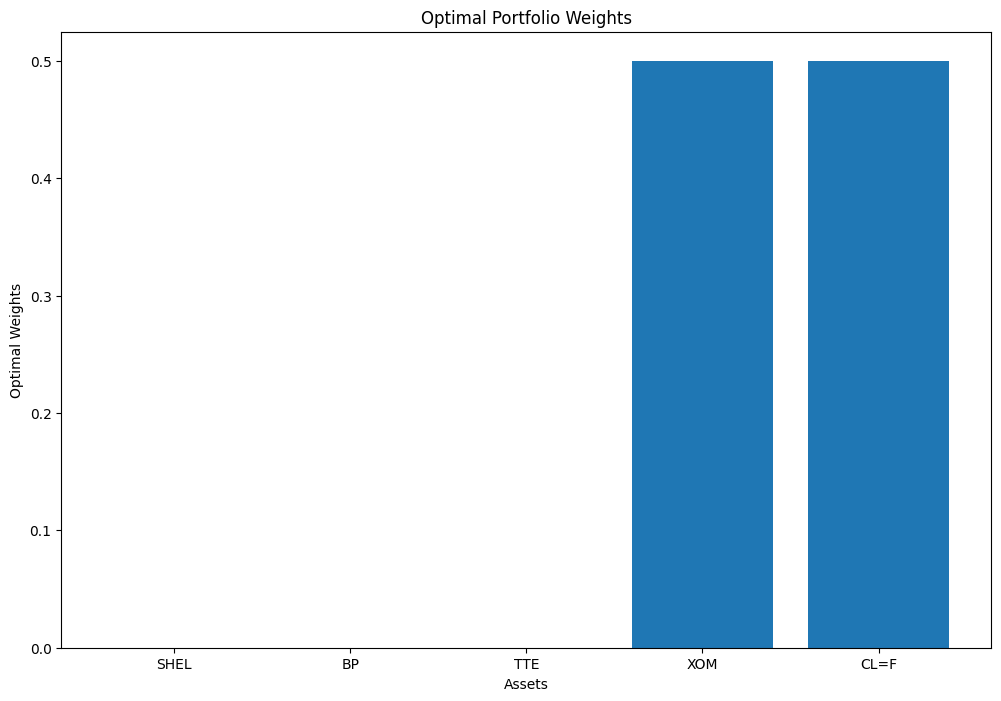

In [82]:

plt.figure(figsize=(12,8))
plt.bar(assets, optimal_weights)
plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')
plt.show()
